# Trends with quasar properties $(M_{i}, M_{BH}, z)$

In [476]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import os
import pandas as pd
import healpy as hp
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

Make Fig. 12, but only plot the distribution of Shen2011, since that's the one I end up using ... '

In [3]:
# Read the Celerite results joined on dbID  to DBQSO  - thus it has DR7 data 
celerite  = Table.read("190409_Celerite_real_Jeff1_radec.txt", format='ascii')

# Add Shen2011
cat = Table.read("../code/dr7_bh_May_2011.fits", format='fits')

# select only those in S82  : select by dec, and crossmatch
shen2011 = cat[abs(cat['DEC']) < 1.5]['SDSS_NAME', 'RA', 'DEC', 'REDSHIFT', 
        'LOGLBOL', 'LOGBH', 'LOGBH_ERR', 'LOGEDD_RATIO','MI_Z2' ]

# crossmatch 
cat1 = SkyCoord(ra=celerite['ra']*u.degree, 
                dec=celerite['dec']*u.degree)
cat2 = SkyCoord(ra=shen2011['RA']*u.degree,
                dec=shen2011['DEC']*u.degree, frame='icrs') 

idx, sep2d, dist3d = cat1.match_to_catalog_sky(cat2) 
qso = hstack([celerite, shen2011[idx]])

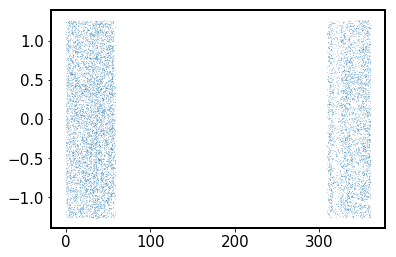

In [9]:
%matplotlib inline
plt.scatter(cat1.ra.deg,  cat1.dec.deg , s=0.01)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


(array([9.660e+02, 4.569e+03, 2.046e+03, 7.950e+02, 3.850e+02, 1.900e+02,
        1.070e+02, 1.820e+02, 5.000e+00, 1.000e+00]),
 array([-0.22452117, -0.05158659,  0.12134799,  0.29428257,  0.46721715,
         0.64015174,  0.81308632,  0.9860209 ,  1.15895548,  1.33189006,
         1.50482465]),
 <a list of 1 Patch objects>)

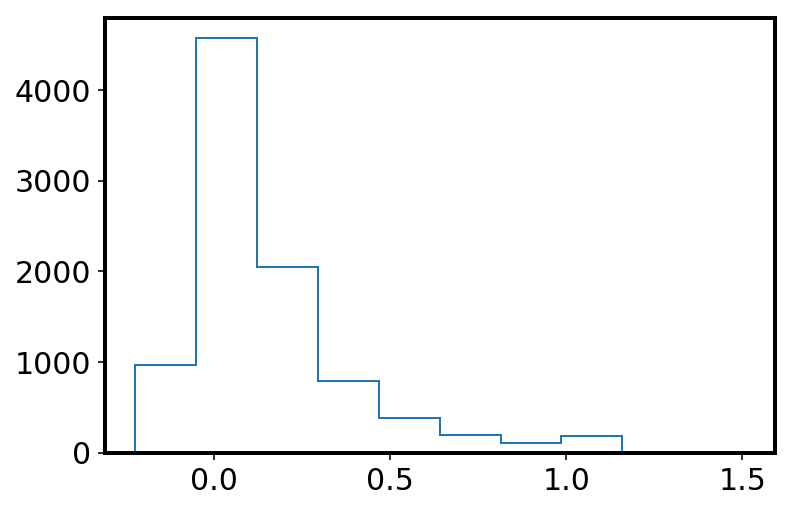

In [111]:
plt.hist(np.log10(qso['sigmaEXP_sdss-ps1']/qso['sigmaEXP_sdss']), histtype='step',
        )

## Fig.12 : Quasar properties 

In [3]:
qso[:3]

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra,dec,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float64,float64,float64,float64,float64,float64,float64,float64
70.txt,3336.9332799999975,0.06622421705058883,0.05984751944546515,122.6490220515577,43.947398211560085,5147.007797999999,--,0.1414213562373095,--,575.0000000000001,70,2.169302,1.238649,301,-23.901,-24.181,1.073,0.0,0.0,20.793,20.469,20.197,20.04,20.0,0.116,000840.63+011419.1,2.1693060398101807,1.2386499643325806,1.073699951171875,45.52781425110629,7.523330610633552,1.5230929717266002,-0.09588690464482141,-24.28560773968867
98.txt,2582.962741999996,0.17768456506773989,0.1425442932431927,926.094822794734,346.4224029622469,4767.016951999998,0.17310108214083317,0.15534946096966964,366.7595534657186,195.0728544419519,98,1.091028,0.962126,144,-23.399,-23.576,0.7867,0.0,0.0,20.79,20.183,19.849,19.818,19.43,0.183,000421.84+005743.6,1.0910290479660034,0.9621239900588989,0.792900025844574,45.421472462631726,8.817950339204,0.1672667771274661,-1.4968484216898403,-23.96421289067481
233.txt,3321.0338420000044,0.10075751425165866,0.08457207262730722,656.8411333494078,193.68268108139895,5505.090184000001,0.08836165515962953,0.08481144613166788,23.17606014197748,15.432798620779016,233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,000119.50+001038.0,0.33128899335861206,0.17722800374031067,1.62090003490448,45.95221191379889,8.921718166686233,0.20424216150370847,-1.0698767980049055,-25.008960685706665


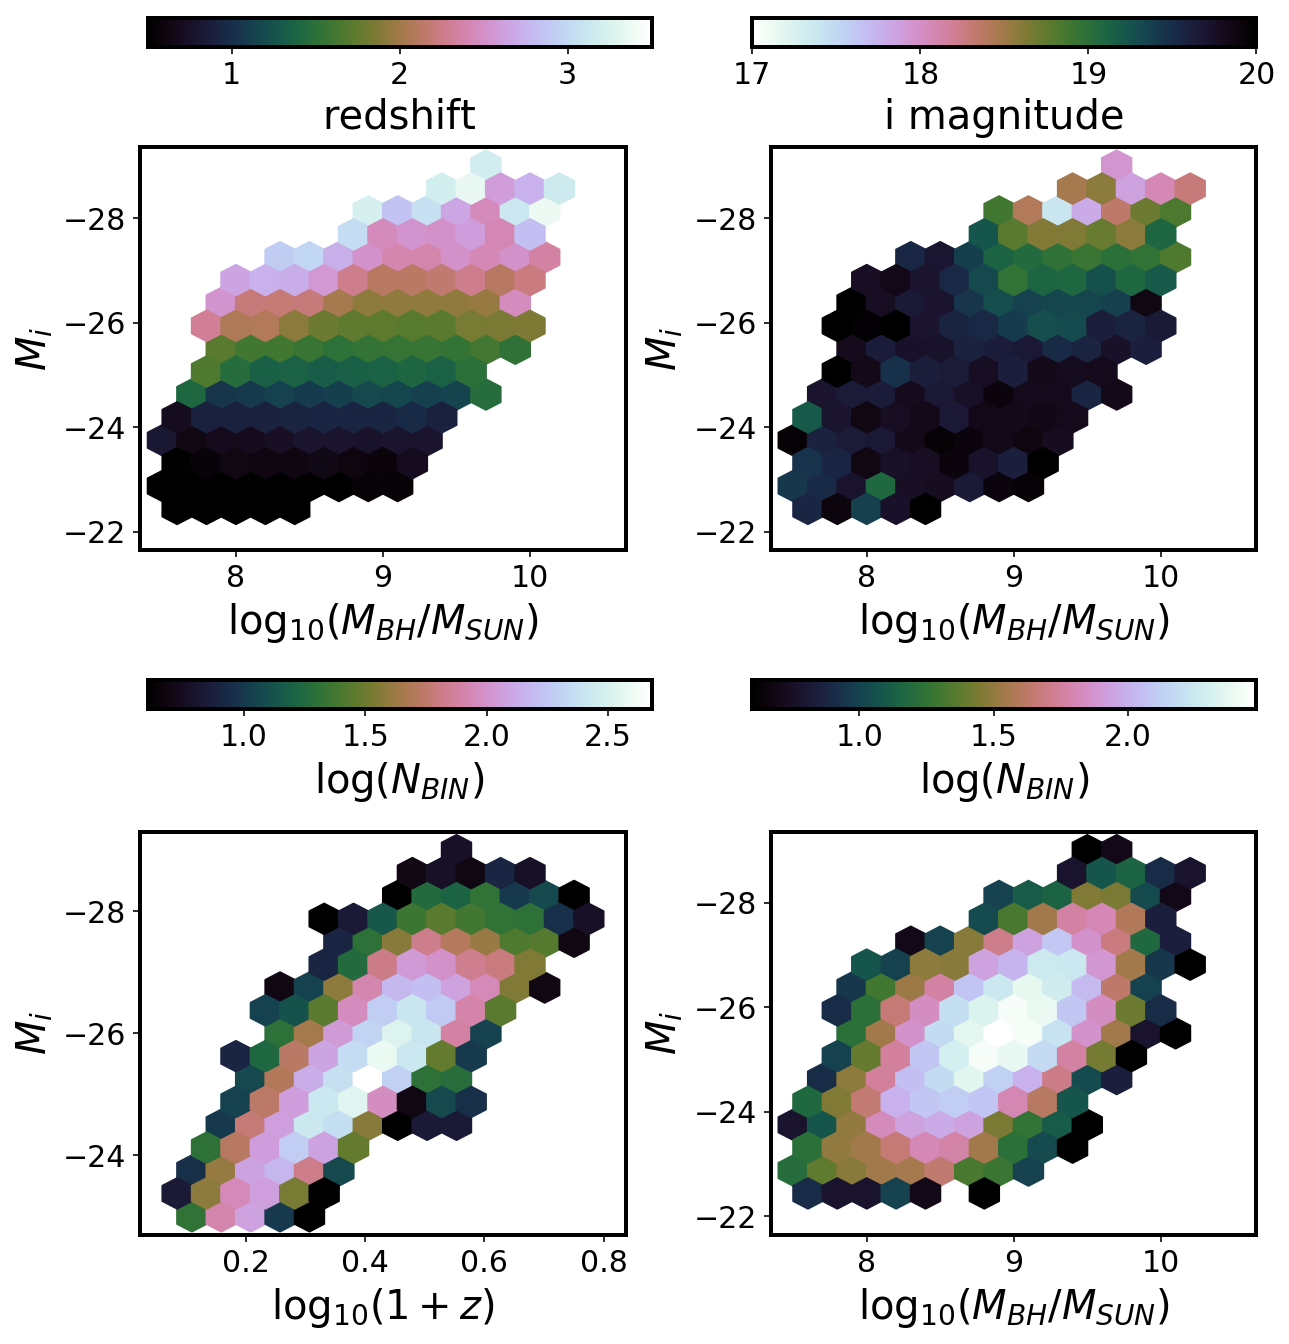

In [6]:
%config InlineBackend.figure_format='retina'

cmap = 'cubehelix'

# plotted quantities : 
# absolute i-band magnitude K-corr to z=2 
MI = qso['MI_Z2'] # Shen2011 

## i-band magnitude  -use DBQSO now, but 
# later perhaps calculate the median of SDSS light curves ?  
# not sure what would be the difference - the light curves are not 
# corrected for extinction, but what about the DBQSO values ? 
imag = qso['i']

# redshift  : Shen2011 
z =  qso['REDSHIFT']

# black hole mass from Shen+2011
MBH = qso['LOGBH']

gridsize=15

fig,axs = plt.subplots(2,2, figsize=(10,10))
ax = np.ravel(axs)

# upper left 
image = ax[0].hexbin(MBH, MI, z , extent = [7.5,10.5, -22,-29], 
                     vmin = 0.5, vmax =3.5, mincnt=4, cmap=cmap, gridsize=gridsize)
ax[0].set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax[0].set_ylabel(r'$M_{i}$')
ax[0].invert_yaxis()

left, bottom, width, height = 0.13, 0.95, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label='redshift')

fig.subplots_adjust(hspace=0.4)


# upper right  
image = ax[1].hexbin(MBH, MI,imag ,
            extent = [7.5,10.5, -22,-29],vmin=17, vmax = 20, mincnt=4,
                     cmap=cmap+'_r', gridsize=gridsize)
ax[1].set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax[1].set_ylabel(r'$M_{i}$')
ax[1].invert_yaxis()

left, bottom, width, height = 0.55, 0.95, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])
cbar = plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label='i magnitude')
#cbar.ax.invert_xaxis()


# lower left 
image = ax[2].hexbin(np.log10(1+z),MI,
            extent = [0.06,0.8, -23,-29],  cmap=cmap,
                    gridsize=gridsize, bins='log',mincnt=4)
#                     vmin = 0.6, vmax =3.5,) 
ax[2].set_xlabel(r'$\log_{10}{(1+z)}$')
ax[2].set_ylabel(r'$M_{i}$')
ax[2].invert_yaxis() 
left, bottom, width, height = 0.13, 0.49, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])

vmin, vmax = image.get_clim()
norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
cbar_cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
cbar_cmap.set_array([])

plt.colorbar(mappable = cbar_cmap, cax = cax, orientation='horizontal',
            label=r'$\log{(N_{BIN})}$')


# lower right 
image = ax[3].hexbin(MBH, MI,extent = [7.5,10.5, -22,-29],  cmap=cmap,
                    gridsize=gridsize, bins='log', mincnt=4
                    ) # vmin = 0.6, vmax =3., 
ax[3].invert_yaxis() 
ax[3].set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax[3].set_ylabel(r'$M_{i}$')
left, bottom, width, height = 0.55, 0.49, 0.35, 0.02
cax = fig.add_axes([left,bottom,width,height])


vmin, vmax = image.get_clim()
norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
cmap.set_array([])

plt.colorbar(mappable = cmap, cax = cax, orientation='horizontal',
            label=r'$\log{(N_{BIN})}$')

fig.subplots_adjust(hspace=0.7,wspace=0.3)
plt.savefig('macleod2010_Fig12_Shen2011.png', bbox_inches='tight', dpi=100)

On colormaps / colorbars 
https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/
 https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots/11558629#11558629
 https://stackoverflow.com/questions/43805821/matplotlib-add-colorbar-to-non-mappable-object
 
 https://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
 https://joseph-long.com/writing/colorbars/
 
 http://emptypipes.org/2014/09/05/python-scaled-colormap/
 http://www.sc.eso.org/~bdias/pycoffee/codes/20160602/colorbar_demo.html
 
 PyCoffee at ESO http://www.sc.eso.org/~bdias/pycoffee/ 

10.0 64.0


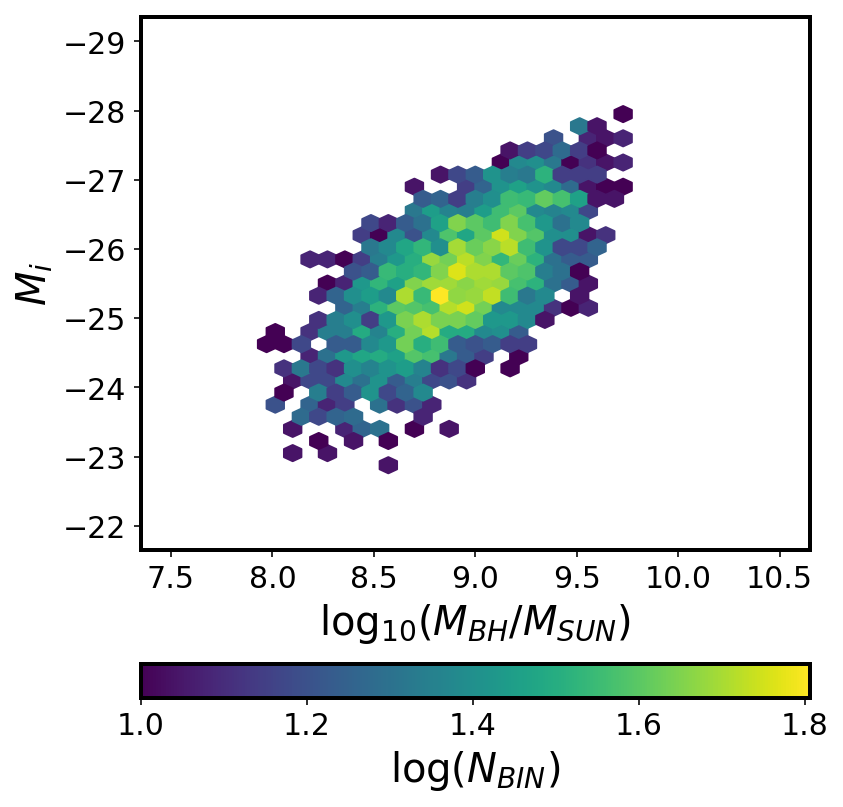

In [7]:
fig,ax =  plt.subplots(1,1,figsize=(6,7))
cmap = 'viridis'
image = ax.hexbin(MBH, MI,extent = [7.5,10.5, -22,-29],  cmap=cmap,
                    gridsize=35, bins='log', mincnt=10.
                    ) # vmin = 0.6, vmax =3., 
ax.invert_yaxis() 
ax.set_xlabel(r'$\log_{10}{(M_{BH} / M_{SUN})}$')
ax.set_ylabel(r'$M_{i}$')
left, bottom, width, height = 0.55, 0.49, 0.35, 0.02

vmin, vmax = image.get_clim()
print(vmin,vmax)
norm = mpl.colors.Normalize(vmin=np.log10(vmin), vmax=np.log10(vmax))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=image.get_cmap())
cmap.set_array([])

plt.colorbar(mappable = cmap, orientation='horizontal',
            label=r'$\log{(N_{BIN})}$')

## Fig.14 : trends with luminosity, black hole mass....

In [107]:
plt.hexbin?

In [53]:
np.sum(~m)

1811

Saved as  macleod2010_Fig14_Shen2011_sdss-ps1.png


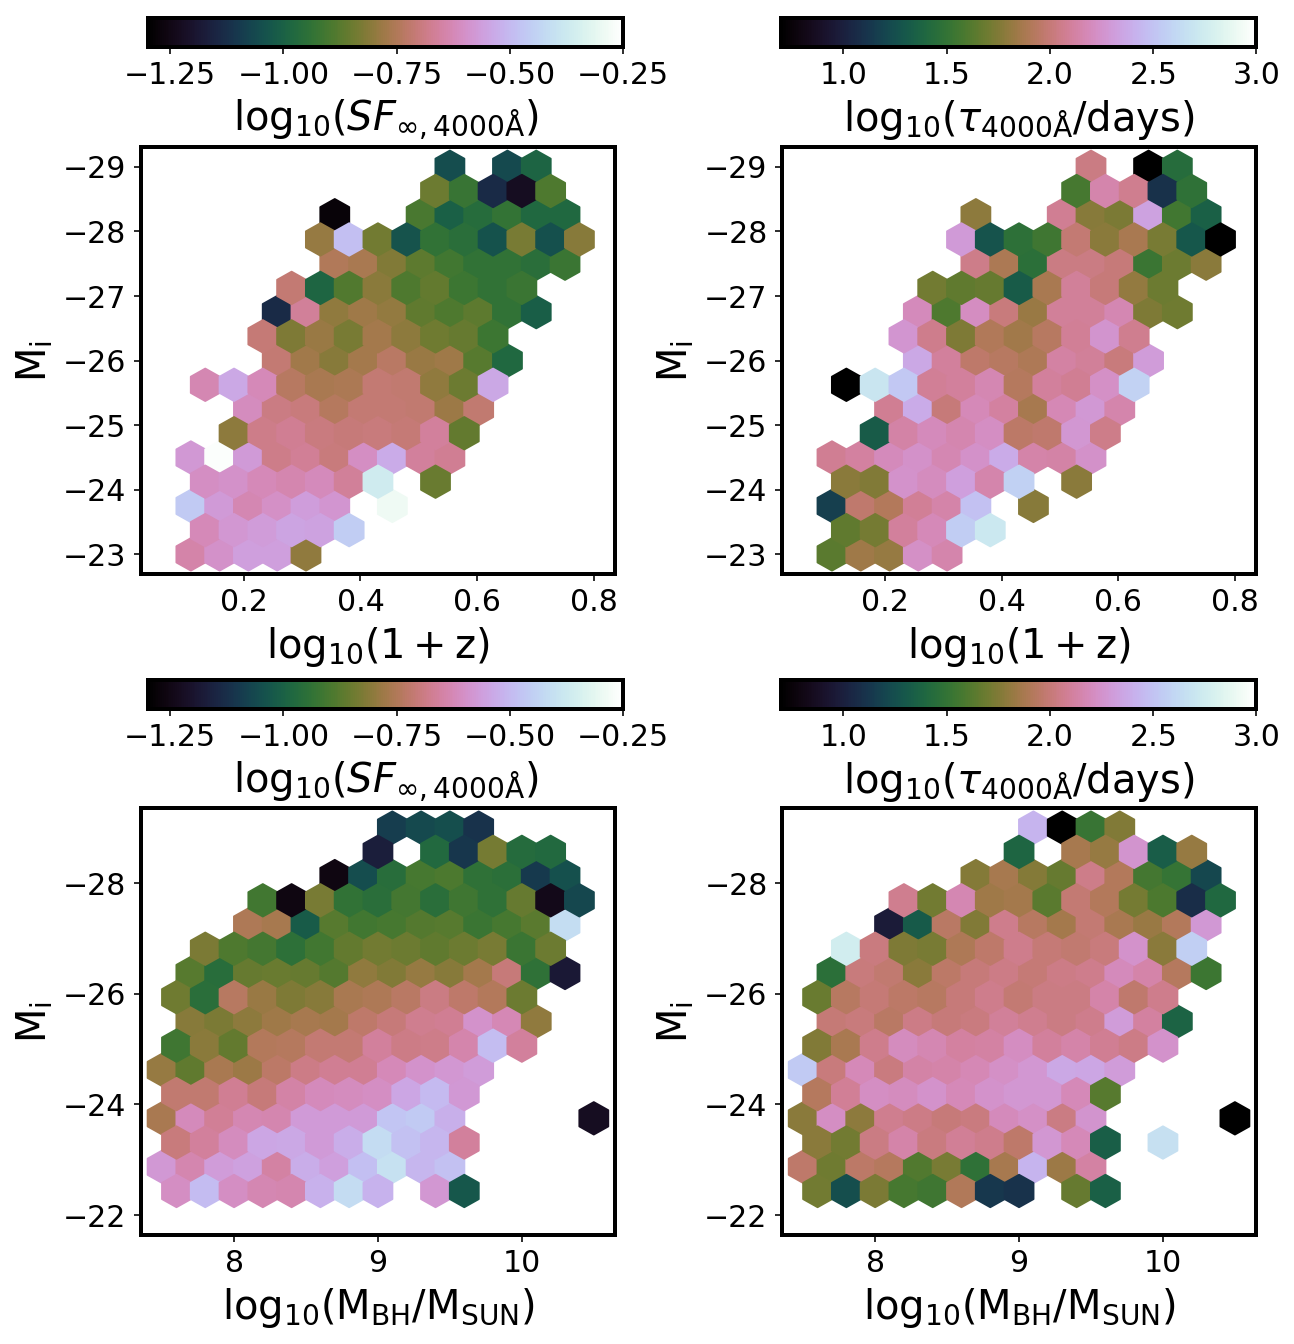

In [8]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
# Make figure like Fig.14 using Chelsea's results ...
fig,axs = plt.subplots(2,2, figsize=(10,10))
ax = np.ravel(axs)
cmap = 'cubehelix'#'magma'# 'viridis'


lambdaobs = 6250 # angstroms  - since these are the results for 
# combined SDSS r-band, centered on 6250 Angstroms 
qso['lambdaRF'] = lambdaobs /  (1.+ qso['REDSHIFT'])

seg = 'sdss-ps1'

tauRF = qso['tauEXP_'+seg] / (1.+ qso['REDSHIFT'])
tau4000 = tauRF * np.power(4000/qso['lambdaRF'], 0.17) # B=0.17 for tau

sfinf = qso['sigmaEXP_'+seg] * np.sqrt(2)
sf4000 = sfinf * np.power(4000/qso['lambdaRF'], -0.479 ) # B = -0.479 for SFinf 


gridsize=15
m = qso['tauEXP_'+seg] > 5 

# plotted quantities : 
# absolute i-band magnitude 
Mi = qso['MI_Z2'][m]
# redshift
z = qso['REDSHIFT'][m]
# black hole mass from Shen+2011 
MBH = qso['LOGBH'][m]


# tau corrected to 4000 A 
tau = tau4000[m]

# sf inf corrected to 4000 A 
sf = sf4000[m]

# upper left 
image = ax[0].hexbin(np.log10(1.+z), Mi, np.log10(sf),
            extent = [0.06,0.8, -23,-29], cmap=cmap, vmin=-1.3, vmax = -0.25,
            gridsize=gridsize)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$\log_{10}{\mathrm{(1+z)}}$')
left, bottom, width, height = 0.13, 0.95, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(SF_{\infty, 4000 \mathrm{\AA}})}$')

fig.subplots_adjust(hspace=0.4)

# upper right 
image = ax[1].hexbin(np.log10(1+z), Mi, np.log10(tau),
            extent = [0.06,0.8, -23,-29], cmap=cmap, vmin=0.7, vmax = 3.0,
                           gridsize=gridsize)
ax[1].invert_yaxis()
ax[1].set_xlabel(r'$\log_{10}{\mathrm{(1+z)}}$')

left, bottom, width, height = 0.57, 0.95, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(\tau _{4000 \mathrm{\AA}}/\mathrm{days})}$')



# lower left 
image = ax[2].hexbin(MBH,Mi, np.log10(sf),
            extent = [7.5,10.5, -22,-29],  cmap=cmap,
                    gridsize=gridsize, 
                     vmin = -1.3, vmax =-0.25, )
ax[2].invert_yaxis() 
ax[2].set_xlabel(r'$\log_{10}{\mathrm{(M_{BH} / M_{SUN})}}$')
left, bottom, width, height = 0.13, 0.49, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(SF_{\infty, 4000 \mathrm{\AA}})}$')

# lower right 
image = ax[3].hexbin(MBH,Mi, np.log10(tau), vmin =0.7, vmax=3.0,
            extent = [7.5,10.5, -22,-29],  cmap=cmap, 
                    gridsize=gridsize, 
                    ) # vmin = 0.6, vmax =3., 
ax[3].invert_yaxis() 
ax[3].set_xlabel(r'$\log_{10}{\mathrm{(M_{BH} / M_{SUN})}}$')
left, bottom, width, height = 0.57, 0.49, 0.33, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(\tau_{4000 \mathrm{\AA}}/\mathrm{days})}$')

for i in range(len(ax)):
    ax[i].set_ylabel(r'$\mathrm{M_{i}}$')

fig.subplots_adjust(wspace=0.35 , hspace=0.55)
#fig.text(0.45,0.99,'Shen+2011', fontsize=19)
figname =  'macleod2010_Fig14_Shen2011_'+seg+'.png'
plt.savefig(figname, bbox_inches='tight', dpi=100)
print('Saved as ', figname)

# Consider the Eddington ratio : Fig.15 ... 

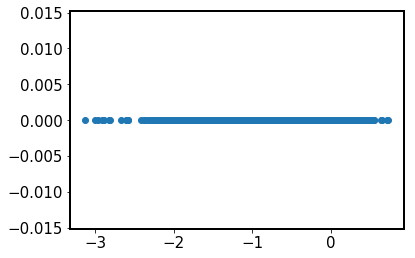

In [21]:
%matplotlib inline
m = qso['LOGEDD_RATIO'] > -4
x = qso['LOGEDD_RATIO'][m]
y = qso['LOGLBOL'][m] - np.log10(1.26) - 38 - qso['LOGBH'][m]
plt.scatter(x, x-y)

Ok , so obviously Shen+2011 assumes that   $L_{Edd} = 1.26 \cdot 10^{38} M_{BH} / M_{\circ}$  rather than  MacLeod+2010  $L_{Edd} = \textbf{1.5}\cdot 10^{38} M_{BH} / M_{\circ}$  


In [37]:
s82r = Table.read('190409_Celerite_real_Jeff1_Shen2008-2011_s82drw_r.txt', format='ascii')

In [39]:
qso = s82r

In [52]:
qso

lcname,length_sdss,sigmaEXP_sdss,sigmaMAP_sdss,tauEXP_sdss,tauMAP_sdss,length_sdss-ps1,sigmaEXP_sdss-ps1,sigmaMAP_sdss-ps1,tauEXP_sdss-ps1,tauMAP_sdss-ps1,dbID,ra_1,dec_1,SDR5ID_1,M_i_1,M_i_corr,redshift_1,mass_BH_1,Lbol,u,g,r,i,z,Au,SDSS_NAME,RA,DEC,REDSHIFT,LOGLBOL,LOGBH,LOGBH_ERR,LOGEDD_RATIO,MI_Z2,SDR5ID_2,ra_2,dec_2,redshift_2,M_i_2,mass_BH_2,chi2_pdf,log10tau,log10sigmahat,log10tau_lim_lo,log10tau_lim_hi,log10sigmahat_lim_lo,log10sigmahat_lim_hi,edge,Plike,Pnoise,Pinf,mu,Npts,SFinf,lambdaRF
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64
70.txt,3336.9332799999975,0.06622421705058883,0.05984751944546515,122.6490220515577,43.947398211560085,5147.007797999999,--,0.1414213562373095,--,575.0000000000001,70,2.169302,1.238649,301,-23.901,-24.181,1.073,0.0,0.0,20.793,20.469,20.197,20.04,20.0,0.116,000840.63+011419.1,2.1693060398101807,1.2386499643325806,1.073699951171875,45.52781425110629,7.523330610633552,1.5230929717266002,-0.09588690464482141,-24.28560773968867,301,2.169302,1.238649,1.073,-23.901,0.0,1.1926,1.90162,-0.686379,1.70316,3.08136,-0.957464,-0.627884,0,138.926,117.218,136.073,20.2857,60,0.09622425731393176,3014.954172696575
98.txt,2582.962741999996,0.17768456506773989,0.1425442932431927,926.094822794734,346.4224029622469,4767.016951999998,0.17310108214083317,0.15534946096966964,366.7595534657186,195.0728544419519,98,1.091028,0.962126,144,-23.399,-23.576,0.7867,0.0,0.0,20.79,20.183,19.849,19.818,19.43,0.183,000421.84+005743.6,1.0910290479660034,0.9621239900588989,0.792900025844574,45.421472462631726,8.817950339204,0.1672667771274661,-1.4968484216898403,-23.96421289067481,144,1.091028,0.962126,0.7867,-23.399,0.0,1.27857,2.72909,-0.7177,2.6183,4.47248,-0.840168,-0.660262,0,123.092,75.9121,122.524,19.8702,52,0.23211252059810764,3498.0690658756366
233.txt,3321.0338420000044,0.10075751425165866,0.08457207262730722,656.8411333494078,193.68268108139895,5505.090184000001,0.08836165515962953,0.08481144613166788,23.17606014197748,15.432798620779016,233,0.331289,0.17723,58,-24.735,-25.058,1.6199,0.0,0.0,20.892,20.554,20.431,20.199,20.099,0.154,000119.50+001038.0,0.33128899335861206,0.17722800374031067,1.62090003490448,45.95221191379889,8.921718166686233,0.20424216150370847,-1.0698767980049055,-25.008960685706665,58,0.331289,0.17723,1.6199,-24.735,0.0,1.19407,2.44022,-0.848145,2.24434,4.1202,-1.02269,-0.781607,0,134.36,107.71,132.865,20.3141,57,0.12325897950662115,2385.587236154052
1018.txt,3336.9333019999976,0.19658989986620978,0.15925866404367295,717.7566916392584,289.67763034974274,5511.071033,0.21944178126621033,0.2084173212910267,2.326795898528782,34.18145321920661,1018,1.364696,-0.098956,190,-23.121,-24.045,0.6125,0.0,45.433,20.098,19.722,19.784,19.485,19.541,0.178,000527.52-000556.2,1.3646990060806274,-0.09895599633455276,0.6123999953269958,45.39391039241853,9.022211072036765,0.2674947222920013,-1.7286712247357983,-24.03915568655799,190,1.364696,-0.098956,0.6125,-23.121,0.0,1.12426,2.87294,-0.627733,2.72995,4.49924,-0.719803,-0.591494,0,152.593,82.2158,152.094,19.4742,62,0.33696948003053717,3875.968992248062
1310.txt,3321.033924000003,0.04259839263300376,0.03745187919140339,383.23865805003277,145.46098372293594,5505.090513000003,0.16782713150619089,0.14034153752344863,1950.7661616699622,982.1410477550927,1310,0.221552,-0.292485,36,-26.451,-26.974,2.7563,9.361,46.76,20.707,19.663,19.61,19.705,19.529,0.174,000053.17-001732.9,0.22155599296092987,-0.29249000549316406,2.7571001052856445,46.78928392693668,9.249395337439456,0.05766163885177335,-0.5604819556203395,-26.916981368954627,36,0.221552,-0.292485,2.7563,-26.451,9.361,0.896713,2.53532,-1.15549

In [556]:
qso = Table.read('../code/s82drw_ugriz_shen2011_shen2008.txt', format='ascii')

In [557]:
#qso

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Saved as  Eddington_ratio_Shen2011_Chelsea_SDSS_ugriz.png


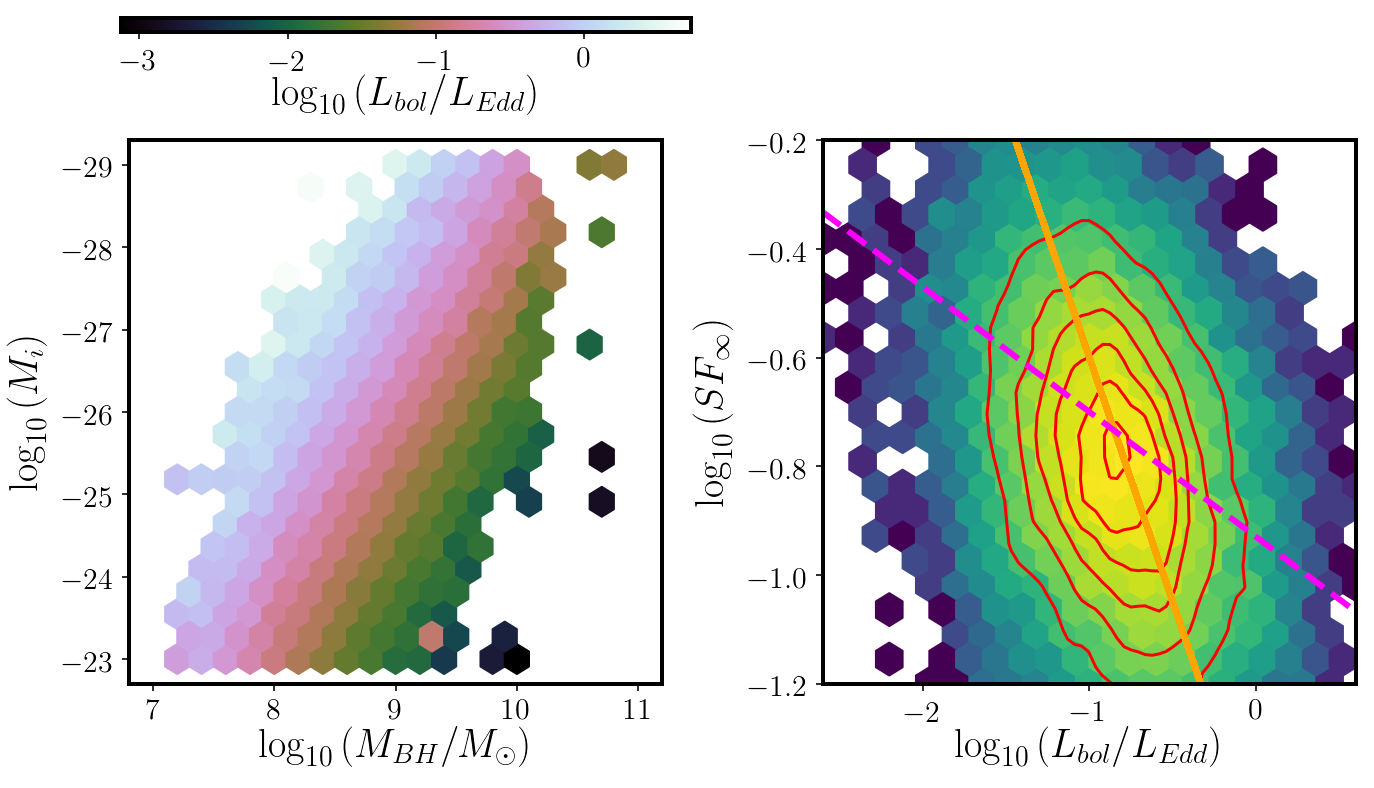

In [558]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import seaborn as sns

cmap = 'cubehelix'

# plotted quantities : 
# absolute i-band magnitude K-corr to z=2 
MI = qso['MI_Z2'] # Shen2011 
#MI = qso['M_i_corr']
# redshift  : Shen2011 
z =  qso['REDSHIFT']
#z = qso['redshift']
# black hole mass from Shen+2011
MBH = qso['LOGBH']
#MBH = qso['mass_BH']

# Eddington ratio : Shen2011
# log(L/LEdd ) = log( L / 1.26e38 MBH / Msun)

logEddRatio = qso['LOGEDD_RATIO'] # Shen2011
#logEddRatio = qso['LOGLBOL'] - np.log10(1.5) - 38 - qso['LOGBH']  # Shen 2011 but with 
# Chlsea's definition of LEdd (1.5 rather than 1.26 )
#logEddRatio = qso['Lbol'] - np.log10(1.5) - 38 - qso['mass_BH_1']  # shen 2008


lambdaobs = 6250 # angstroms  - since these are the results for 
# combined SDSS r-band, centered on 6250 Angstroms 
lambdaRF = lambdaobs /  (1.+z)

seg = 'sdss-ps1' # sdss'# 'sdss-ps1'

#tauRF = qso['tauEXP_'+seg] / (1.+z)  # shift to rest frame 
#tau4000 = tauRF * np.power(4000/lambdaRF, 0.17) # B=0.17 for tau

#sfinf = qso['sigmaEXP_'+seg] * np.sqrt(2) # no need to shift anything 
sfinf = qso['SFinf']
#sf4000 = sfinf * np.power(4000 / lambdaRF, -0.479 ) # B = -0.479 for SFinf 
sf4000 = qso['SFinf4000']

fig,axs = plt.subplots(1,2, figsize=(11,5))
ax = np.ravel(axs)

gridsize=20
m = logEddRatio  >  -4 
#m = (qso['tauEXP_'+seg] > 5 )&(logEddRatio > -4)


if seg == 'sdss-ps1':
    extent0 = [7,11, -23,-29]
    extent1 = [-2.6,0.6, -1.2,-0.2]
    
if seg == 'sdss':
    extent0 = [7,11, -23,-29]
    extent1 = [-2.6,0.6, -1.2,-0.2]
    
# left panel 
image = ax[0].hexbin(MBH[m], MI[m], logEddRatio[m],
            extent = extent0, cmap=cmap, gridsize=gridsize)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
ax[0].set_ylabel(r'$\log_{10}{(M_{i})}$')


left, bottom, width, height = 0.12, 1.03, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(L_{bol} / L_{Edd} )}$')

# right panel

#ax[1].scatter(logEddRatio, np.log10(sf4000), s=0.05, c='blue')
x,y = logEddRatio[m].data, np.log10(sf4000[m].data)


ax[1].set_xlim(extent1[0],extent1[1])
ax[1].set_ylim(extent1[2],extent1[3])
ax[1].hexbin(x,y,bins='log',mincnt=1, gridsize=gridsize,
            extent = extent1)


# contours with single color
sns.kdeplot(x,y, n_levels=6, ax=ax[1],
                linestyles='-', linewidth=2, cmap=None, colors='red', )
# shaded contours
#sns.kdeplot(x,y, n_levels=6, ax=ax[1],
#                linestyles='-', linewidth=2, cmap='Blues_r', )


# plot the medians too ..
xlim = ax[1].get_xlim()
min_x, max_x , step_size = xlim[0],xlim[1], 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))
for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
    median_y[j] = np.median(y[mask])
#ax[1].scatter(mean_x[:-1], median_y[:-1], c = 'magenta', )


# stats on log ... 
#stats = binned_statistic(x,y,statistic = 'median', bins=40)
#bins = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2
#ax[1].scatter(bins,  stats.statistic,  c = 'magenta', edgecolors='orange')

#bins =  np.linspace(np.power(10,xmin), np.power(10,xmax), 40)
#stats = binned_statistic(np.power(10,x), np.power(10,y), statistic='median', bins=bins)
#bins = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2
#ax[1].scatter(np.log10(bins),  np.log10(stats.statistic),
#              c = 'magenta', edgecolors='orange')





# overplot a straight line fit ..
#from scipy.optimize import curve_fit
def func(x, a, b):
    return a*x + b

#popt, pcov = curve_fit(func, x, y)
#ax[1].plot(x, func(x, *popt), 'r-',)
#...          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))



ax[1].set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
ax[1].set_xlabel(r'$\log_{10}{(L_{bol} / L_{Edd})}$')

ax[1].plot(x, func(x,-0.9, -1.5 ), ls = '--', lw=3, c='orange',label='-0.9')

# plot Chelsea's slope...
x_ = np.linspace(-2.6,0.6)
ax[1].plot(x_, -0.23*x_ - 0.93, lw=3, ls='--', c='magenta', label='-0.23')

#ax[1].legend(loc='upper left', bbox_to_anchor=(1,1),
#            ncol=1, fancybox=True, shadow=True, fontsize=18 ) 

fig.subplots_adjust(wspace=0.3)
#plt.savefig('macleod2010_Fig15_shen2011_SDSS-PS1.png', bbox_inches='tight')
#fname =  'Eddington_ratio_Shen2011_'+seg+'.png'
fname =  'Eddington_ratio_Shen2011_Chelsea_SDSS_ugriz.png'
print('Saved as ', fname)
plt.savefig(fname,   bbox_inches='tight', dpi=100)

In [66]:
len(x)

32936

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


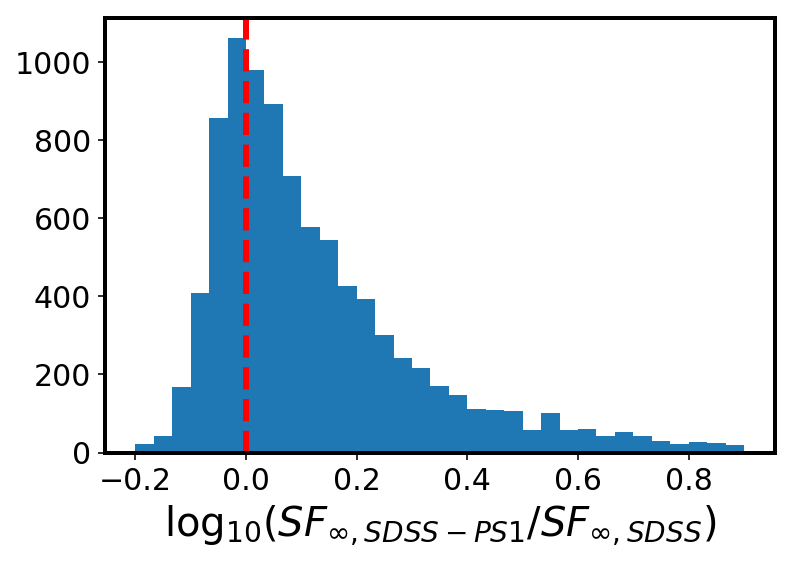

In [36]:
# Compare the two SFinf ...

sfinf1 = qso['sigmaEXP_sdss-ps1'] * np.sqrt(2) # no need to shift anything 
sf4000_1 = sfinf1 * np.power(4000/lambdaRF, -0.479 ) # B = -0.479 for SFinf 

sfinf2 = qso['sigmaEXP_sdss'] * np.sqrt(2) # no need to shift anything 
sf4000_2 = sfinf1 * np.power(4000/lambdaRF, -0.479 ) # B = -0.479 for SFinf 


plt.hist(np.log10(sfinf1 / sfinf2), bins=33, range=(-0.2, 0.9))
plt.axvline(0, ls='--', lw=3,c='r')
#plt.xlim(-0.3, 0.9)
plt.xlabel(r'$\log_{10}{(SF_{\infty, SDSS-PS1} / SF_{\infty,  SDSS} )}$')
plt.savefig('Compare_SFinf_4000AA_Celerite.png', bbox_inches='tight', dpi=100)

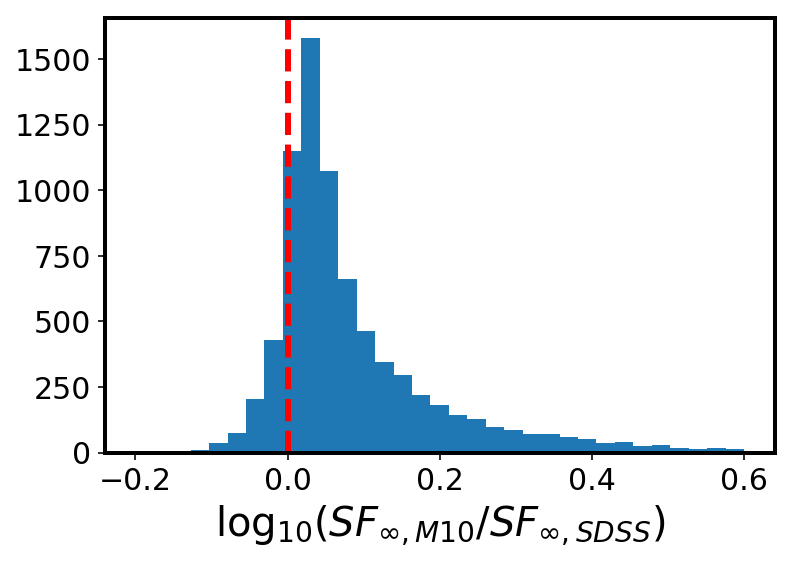

In [47]:
# Compare the two SFinf ...
sfinf1 = qso['SFinf'] #qso['sigmaEXP_sdss-ps1'] * np.sqrt(2) # no need to shift anything 
sf4000_1 = sfinf1 * np.power(4000/lambdaRF, -0.479 ) # B = -0.479 for SFinf 

sfinf2 = qso['sigmaEXP_sdss'] * np.sqrt(2) # no need to shift anything 
sf4000_2 = sfinf1 * np.power(4000/lambdaRF, -0.479 ) # B = -0.479 for SFinf 


plt.hist(np.log10(sfinf1 / sfinf2), bins=33, range=(-0.2, 0.6))
plt.axvline(0, ls='--', lw=3,c='r')
#plt.xlim(-0.3, 0.9)
plt.xlabel(r'$\log_{10}{(SF_{\infty, M10} / SF_{\infty,  SDSS} )}$')
plt.savefig('Compare_SFinf_4000AA_Celerite_Chelsea.png', bbox_inches='tight', dpi=100)

In [68]:
stats.statistic

array([-0.80674312, -0.67726086, -1.02824732,         nan, -0.39630279,
               nan, -0.48048727, -0.63348159, -0.68665524, -0.75842155,
       -0.48850667, -0.50216794, -0.5731691 , -0.57590331, -0.59614473,
       -0.62426178, -0.61356717, -0.64878623, -0.66856974, -0.67955962,
       -0.68339228, -0.71942388, -0.72517475, -0.74397096, -0.76662836,
       -0.78049892, -0.7885407 , -0.80843638, -0.83368093, -0.82899181,
       -0.84566301, -0.83088883, -0.90046967, -0.94746409, -0.84874961,
       -0.96970596, -0.8764347 , -0.85215692, -0.88857812, -1.16757747])

Check the K-correction factors from http://www.astrouw.edu.pl/~simkoz/AGNcalc/ : are they to z=2 or z=0 ? Plot k as a function of redshift

In [5]:
k = Table.read("Kcorr_QSO_r.dat.txt", format='ascii',names=['z',"K"])

Text(0, 0.5, 'K corr')

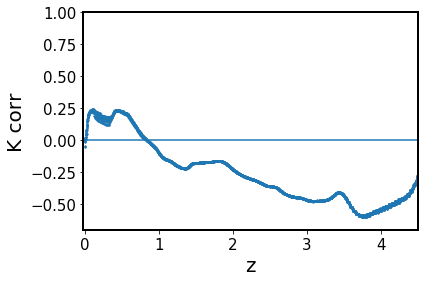

In [23]:
%matplotlib inline
plt.scatter(k['z'], k['K'],s=2 )
plt.ylim(-0.7,1)
plt.xlim(-0.02,4.5)
plt.axhline(0)
plt.xlabel('z')
plt.ylabel("K corr")

it is 0 at z=0 as well as z~0.75 .... Thus I think he's correcting to z=0.

In [6]:
x

array([[-2.77770063, -2.21179288],
       [-2.96869531,  0.20040625],
       [-1.95008602, -3.33216565],
       ...,
       [ 2.28435697,  2.66877899],
       [-0.5436443 ,  0.4007885 ],
       [ 1.68840284,  1.19997144]])

Do the test : 
* generate a y = f(x) distribution where slope is known , eg. 2D Gaussian  https://www.astroml.org/book_figures/chapter3/fig_bivariate_gaussian.html 
* fit with AstroML total least squares for slope
* add errors
* fit again, see how errors affect the recovered slope ... 

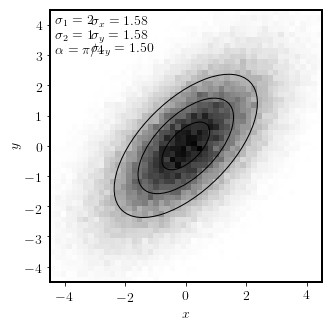

In [62]:
from matplotlib.patches import Ellipse
from astroML.stats.random import bivariate_normal
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

#------------------------------------------------------------
# Define the mean, principal axes, and rotation of the ellipse
mean = np.array([0, 0])
sigma_1 = 2
sigma_2 = 1
alpha = np.pi / 4

#------------------------------------------------------------
# Draw 10^5 points from a multivariate normal distribution
#
#   we use the bivariate_normal function from astroML.  A more
#   general function for this is numpy.random.multivariate_normal(),
#   which requires the user to specify the full covariance matrix.
#   bivariate_normal() generates this covariance matrix for the
#   given inputs.
np.random.seed(0)
x, cov = bivariate_normal(mean, sigma_1, sigma_2, alpha, size=100000,
                          return_cov=True)

sigma_x = np.sqrt(cov[0, 0])
sigma_y = np.sqrt(cov[1, 1])
sigma_xy = cov[0, 1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# plot a 2D histogram/hess diagram of the points
H, bins = np.histogramdd(x, bins=2 * [np.linspace(-4.5, 4.5, 51)])
ax.imshow(H, origin='lower', cmap=plt.cm.binary, interpolation='nearest',
          extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])

# draw 1, 2, 3-sigma ellipses over the distribution
for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean, N * sigma_1, N * sigma_2,
                         angle=alpha * 180. / np.pi, lw=1,
                         ec='k', fc='none'))

kwargs = dict(ha='left', va='top', transform=ax.transAxes)

ax.text(0.02, 0.98, r"$\sigma_1 = %i$" % sigma_1, **kwargs)
ax.text(0.02, 0.93, r"$\sigma_2 = %i$" % sigma_2, **kwargs)
ax.text(0.02, 0.88, r"$\alpha = \pi / %i$" % (np.pi / alpha), **kwargs)

ax.text(0.15, 0.98, r"$\sigma_x = %.2f$" % sigma_x, **kwargs)
ax.text(0.15, 0.93, r"$\sigma_y = %.2f$" % sigma_y, **kwargs)
ax.text(0.15, 0.88, r"$\sigma_{xy} = %.2f$" % sigma_xy, **kwargs)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

In [14]:
np.zeros_like(x)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [63]:
# we can assume that the points above have no errors at all...
# then the recovered slope should align with the principal ellipse axis, i.e.
# slope should be 0.5 

from scipy import optimize
from astroML.linear_model import TLS_logL

# Fit x1 and y1 :  
# stack the latent variables x1,y1  ....
#X = np.vstack((x1, y1)).T
#dX = np.zeros((len(x1), 2, 2))
# x as constructed above is already a (N,2) array \
# which is exactly what we get by 
# operating with X = np.vstack((x1,y1)).T
# if the two arrays have length N,
# shape of X is (N,2)

x1,y1 = np.vsplit(x.T,2) #  undoes the operation 
X = np.vstack((x1, y1)).T
dX = np.zeros((len(x1), 2, 2))
#dX = np.zeros_like(x)  # : no errors whatsoever. ...
dX[:, 0, 0] = 0.00001 #sigma_lum ** 2
dX[:, 1, 1] = 0.00001 #sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = 0 # no cross-covariance ... 
    
    
min_func = lambda beta: -TLS_logL(beta, X, dX)
beta_fit = optimize.fmin(min_func,x0=[1,1])
print(beta_fit)
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b

slope, offset  = get_m_b(beta_fit)
print('offset ', offset, 'slope ', slope)

AssertionError: 

[0.59875969 0.00741086]


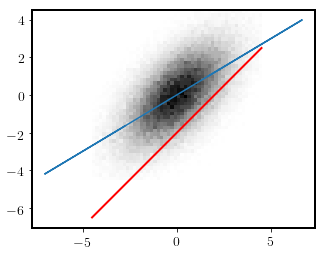

In [54]:
%matplotlib inline
fig,ax  = plt.subplots()
ax.imshow(H, origin='lower', cmap=plt.cm.binary, interpolation='nearest',
          extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])
x_fit = np.linspace(bins[0][0], bins[0][-1])
ax.plot(x_fit, -slope * x_fit - offset, '-r',lw=2)

x1,y1 = np.vsplit(x.T,2)
z = np.polyfit(x1[0],y1[0],1)
print(z)
p = np.poly1d(z)

#plt.scatter(x1,y1,s=0.0001)
ax.plot(x1[0], p(x1[0]))

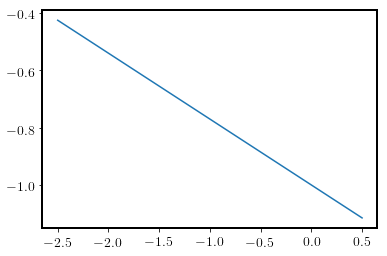

In [67]:
x = np.linspace(-2.5,0.5,1000)
y = -0.23 * x - 1
plt.plot(x,y)

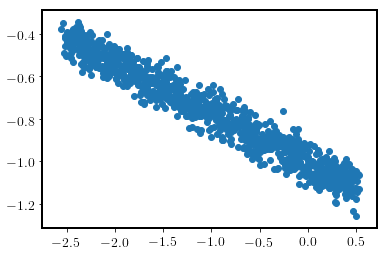

In [76]:
x = np.linspace(-2.5,0.5,1000)
y = -0.23 * x - 1
plt.plot(x,y)
xobs = x + np.random.normal(0,0.05, len(x))
yobs = y + np.random.normal(0,0.05, len(x))
plt.scatter(xobs,yobs)

Rotation angle is  -0.2260683879938839  rad
i.e.  -12.952764513375518  deg
True slope :  -0.23
Fitting observed distr, assuming considerable obs error 
sigma_x= 0.2  sigma_y= 0.01
Optimization terminated successfully.
         Current function value: 429684.483065
         Iterations: 63
         Function evaluations: 120
Recovered slope with AstroML (incl.errors):  -1.8021219917558666
Fitting bivariate normal recovered slope is  -0.23045138311602886
Fitting bivariate normal recovered alpha is  -0.226497050341176


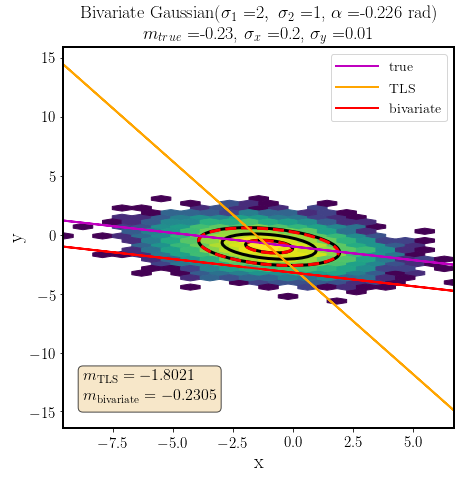

In [553]:
from astroML.stats import fit_bivariate_normal
mean = [-1,-1]
stdev_1 = 2 # distribution spread in x direction before rotation 
stdev_2 = 1 # distribution spread in y direction before rotation
slope = -0.23 # 0.5#-0.23 # the slope in the desired target distribution 
#slope=0.5
#  a basis for calculating the rotation angle 
rotation =  np.arctan(slope)  #  rotation angle in radians 
print('Rotation angle is ', rotation ,' rad')
print('i.e. ',np.rad2deg(rotation), ' deg')
# generate bivariate Gaussian 
x, cov = bivariate_normal(mean, stdev_1, stdev_2, rotation, size=10000,
                          return_cov=True)

#stdev_x =np.sqrt(cov[0, 0])
#stdev_y = np.sqrt(cov[1, 1])
#cov_xy = cov[0, 1]

print('True slope : ', slope)
# plot it 
x1,y1 = np.vsplit(x.T,2)
x1 = x1[0]
y1 = y1[0]

# add to observed x,y  values an offset drawn from a Gaussian distribution....
# otherwise we're fitting an intrinsic, but not the observed, distribitopn...

fit_parent = False
if fit_parent : 
    print('Fitting parent distr, assuming tiny observational error ')
    sigma_x = 1e-6
    sigma_y = 1e-6  # basically no error 
    print('sigma_x = sigma_x = ', sigma_x)
    
if not fit_parent : #  fitting the observed distribution : 
    # adding the observational error 
    # Chelsea assumed error on SFinf as 0.01 # yvar in the sf model in idl file...
    print('Fitting observed distr, assuming considerable obs error ')
    sigma_x = 0.2  # error on log(L/Ledd), 
                   # corresponding to error on log(MBH), which is 0.2
    sigma_y = 0.01 # error on SFinf , Chelsea assumes 0.01 in the IDL code 
    print('sigma_x=',sigma_x, ' sigma_y=', sigma_y )
    
# to the underlying dist. add observed error
xobs = x1  + np.random.normal(0,sigma_x, len(x1))
yobs = y1  + np.random.normal(0,sigma_y, len(y1))
   

fig,ax = plt.subplots(1,1, figsize=(7,7))
# plt.scatter(x1,y1)
#ax.errorbar(x1,y1,sigma_x,sigma_y, fmt='none', ecolor='b', capthick=2)


import seaborn as sns

# plot the observed distribution ... 
cmap = 'viridis' ; gridsize=20 
ax.hexbin(xobs,yobs,bins='log',mincnt=1, gridsize=gridsize,)
#            extent = extent1)

# plot the parent distribution slope
ax.plot(xobs,slope*xobs+mean[0],lw=2, c='m', label='true')

# draw 1, 2, 3-sigma ellipses over the true distribution
for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean, N * stdev_1, N * stdev_2,
                         angle=rotation * 180. / np.pi, lw=3,
                         ec='k', fc='none'))
    
# contours with single color
#sns.kdeplot(x1,y1, n_levels=6, ax=ax,
#                linestyles='-', linewidth=2, cmap=None, colors='red', )


# fit with polyfit ...
#z = np.polyfit(x1,y1,1)
#poly = np.poly1d(z)
#plt.plot(x1,poly(x1), lw=2, c='r', ls='--')
#print('Recovered slope with polyfit (no errors):  ', z[0])
#

# fit with AstroML
# http://www.astroml.org/book_figures/chapter8/fig_total_least_squares.html
X_ = np.vstack((xobs,yobs)).T
dX =  np.zeros((len(xobs), 2, 2))
dX[:,0,0] = sigma_x ** 2.0 
dX[:,1,1] = sigma_y ** 2.0 
dX[:,0,1] = dX[:,1,0] = 0 # cov_xy

min_func = lambda beta: -TLS_logL(beta, X_, dX)
beta_fit = optimize.fmin(min_func,x0=[1,-1])
#print(beta_fit)
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b
slope_tls, offset  = get_m_b(beta_fit)
print('Recovered slope with AstroML (incl.errors): ', slope_tls)
ax.plot(xobs, slope_tls*xobs+offset, ls='-',lw=2,c='orange', label='TLS')


# fit with astroML code, robust fit 
(mu_r, sigma1_r, sigma2_r, alpha_r) = fit_bivariate_normal(xobs, yobs, robust=True)
slope_r = np.tan(alpha_r) # alpha is rotation in radians 
for Nsig in [1, 3]:
    E = Ellipse(mu_r, sigma1_r * Nsig, sigma2_r * Nsig, (alpha_r * 180. / np.pi),
                    ec='r', fc='none', linestyle='dashed',lw=3)
    ax.add_patch(E)
print('Fitting bivariate normal recovered slope is ', slope_r )
print('Fitting bivariate normal recovered alpha is ', alpha_r)
ax.plot(xobs, slope_r*xobs+offset-0.4, ls='-',lw=2,c='red',
       label='bivariate')


ax.legend()
ax.set_title('Bivariate Gaussian('+r'$\sigma_{1}=$'+str(stdev_1)+\
            r'$,\,\,\sigma_{2}=$'+str(stdev_2)+r', $\alpha=$'+\
             str(rotation.round(3))+' rad) '+'\n'+r'$m_{true} = $'+\
             str(slope)+', '+r'$\sigma_{x}=$'+str(sigma_x)+\
             r',  $\sigma_{y}=$'+str(sigma_y))
ax.set_xlabel('x')
ax.set_ylabel('y')

# ax.text(0.1,0.2,r'$m_{TLS} = $'+str(slope_tls.round(3)),
#         transform=ax.transAxes)
# ax.text(0.1,0.1,r'$m_{biv} = $'+str(slope_r.round(3)),
#         transform=ax.transAxes)
textstr = '\n'.join((
    r'$m_{\mathrm{TLS}}=%.4f$' % (slope_tls, ),
    r'$m_{\mathrm{bivariate}}=%.4f$' % (slope_r, )
                    ))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)

# place a text box in upper left in axes coords
ax.text(0.05, 0.15, textstr, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

plt.savefig('Bivariate_dist_fit_TLS_biv.png', bbox_inches='tight', dpi=100)

* with AstroML Total Least Squares, if I assume true errors , I get grossly wrong slope - but perhaps it is incorrect to tell astromL that there is no covariance whereas in reality all points are related in some way ... (?)
- if I feed it with the real covariance it gets it wrong, but that's because it's asking for error covariance , not covariance of the entire distribution...
* if I assume tiny errors for AstroML,  I get the right answer ...
* if I use the fit_bivariate_normal() from astroML, I get the right answer of course....(plotting the recovered means, stdevs, rotation with dashed ellipses)

Iterate over a range of x errors and see how the answer changes.. Fix y error at 0.001 :

In [240]:

def fit_tls_bivariate(x, sigma_x, sigma_y, verbose=False):
    x1,y1 = np.vsplit(x.T,2)
    x1 = x1[0]
    y1 = y1[0]
    if verbose:
        print('sigma_x=',sigma_x, ' sigma_y=', sigma_y )
    
    # to the underlying dist. add observed error
    x1 = x1  + np.random.normal(0,sigma_x, len(x1))
    y1 = y1  + np.random.normal(0,sigma_y, len(y1))
    
    # fit with AstroML
    # http://www.astroml.org/book_figures/chapter8/fig_total_least_squares.html
    X = np.vstack((x1,y1)).T
    dX =  np.zeros((len(x1), 2, 2))
    dX[:,0,0] = sigma_x ** 2.0 
    dX[:,1,1] = sigma_y ** 2.0 
    dX[:,0,1] = dX[:,1,0] = 0 # cov_xy : we assume errors are uncorrelated 

    min_func = lambda beta: -TLS_logL(beta, X, dX)
    beta_fit = optimize.fmin(min_func,x0=[1,-1], disp=0)
    #print(beta_fit)
    def get_m_b(beta):
        b = np.dot(beta, beta) / beta[1]
        m = -beta[0] / beta[1]
        return m, b
    slope_tls, offset  = get_m_b(beta_fit)
    if verbose:
        print('Recovered slope with AstroML (incl.errors): ', slope_tls)
        
    # fit with astroML code, robust fit 
    (mu_r, sigma1_r, sigma2_r, alpha_r) = fit_bivariate_normal(x1, y1, robust=True)
    slope_bivariate = np.tan(alpha_r) # alpha is rotation in radians 
    if  verbose : 
        print('Fitting bivariate normal recovered slope is ', slope_bivariate )
    return slope_tls, slope_bivariate

In [250]:
sigma_x_grid = np.logspace(-4,-1,100)
sigma_y_grid = np.logspace(-4,-1,100)

N = len(sigma_x_grid) * len(sigma_y_grid )
sig_x_col = np.zeros(N)
sig_y_col =  np.zeros(N)
sl_tls_col=  np.zeros(N)
sl_biv_col = np.zeros(N)
i = 0 
for sigma_x in sigma_x_grid:
    if i % 100 == 0 :
        print(i)
    for sigma_y in sigma_y_grid:
        slope_tls, slope_bivariate = fit_tls_bivariate(x, sigma_x,sigma_y, 
                                                       verbose=False)
        sig_x_col[i] = sigma_x
        sig_y_col[i] = sigma_y
        sl_tls_col[i] =  slope_tls
        sl_biv_col[i] = slope_bivariate
        i += 1 

        

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [251]:
t = Table(data = [sig_x_col, sig_y_col, sl_tls_col, sl_biv_col],
     names=['sigma_x', 'sigma_y', 'slope_tls', 'slope_biv'])
t.write('Fit_slope_bivariate_Gaussian.txt', format='ascii')

(array([2551.,  608.,  247.,  237.,  173.,  177.,  181.,  279., 2065.,
        3470.]),
 array([-1.8 , -1.62, -1.44, -1.26, -1.08, -0.9 , -0.72, -0.54, -0.36,
        -0.18,  0.  ]),
 <a list of 10 Patch objects>)

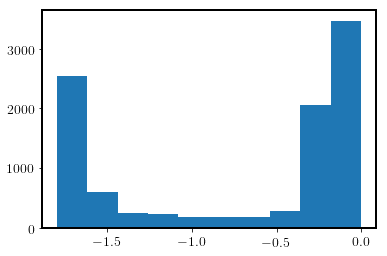

In [418]:
plt.hist(t['slope_tls'], range=(-1.8,0))

In [326]:
plt.hexbin?

(0, 8)

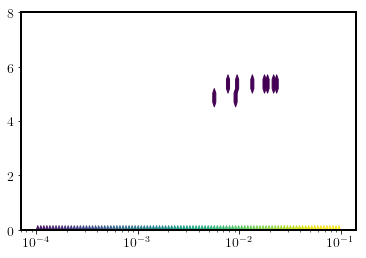

In [337]:
plt.hexbin(t['sigma_y'],t['slope_tls'], mincnt=1, xscale='log',)#extent=(-4,-1,5,5))
plt.ylim(0,8)

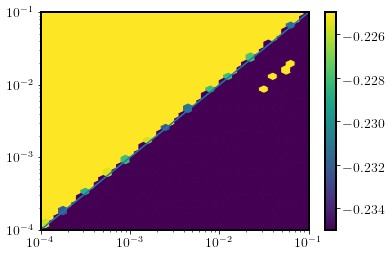

In [437]:
slope_truth = -0.23 

plt.hexbin(t['sigma_x'], t['sigma_y'] ,t['slope_tls'],
          xscale='log', yscale='log', vmin=-0.235, vmax=-0.225
           ,gridsize=30,)
plt.plot(t['sigma_x'],t['sigma_x'])
plt.colorbar()# vmin=0, vmax=8,

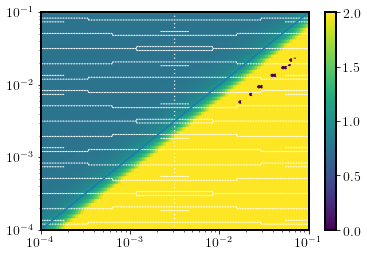

In [442]:
slope_truth = -0.23 

plt.hexbin(t['sigma_x'], t['sigma_y'] ,t['slope_tls']/slope_truth,vmin=0,vmax=2,
          xscale='log', yscale='log', )
plt.plot(t['sigma_x'],t['sigma_x'])
plt.colorbar()# vmin=0, vmax=8,

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


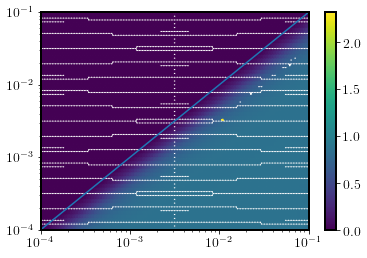

In [462]:
z = np.log10(t['slope_tls'].data/slope_truth)
plt.hexbin(t['sigma_x'], t['sigma_y'] ,z,vmin=0,
          xscale='log', yscale='log', mincnt=0)
plt.plot(t['sigma_x'],t['sigma_x'])
plt.colorbar()

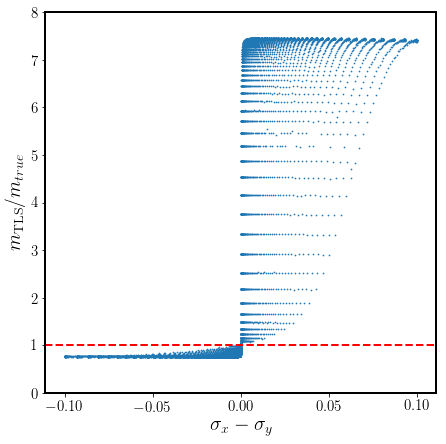

In [554]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(t['sigma_x'] - t['sigma_y'] , t['slope_tls']/slope_truth, s=0.5)
ax.set_ylim(0,8)
ax.axhline(1,ls='--', lw='2', c='r')
ax.set_ylabel(r'$m_{\mathrm{TLS}} / m_{true}$')
ax.set_xlabel(r'$\sigma_{x} - \sigma_{y}$')
plt.savefig('bivariate_fit_sig_x_sig_y_TLS.png', bbox_inches='tight', dpi=100)

The transition for TLS occurs precisely where the x-errors start being bigger than the y-errors...

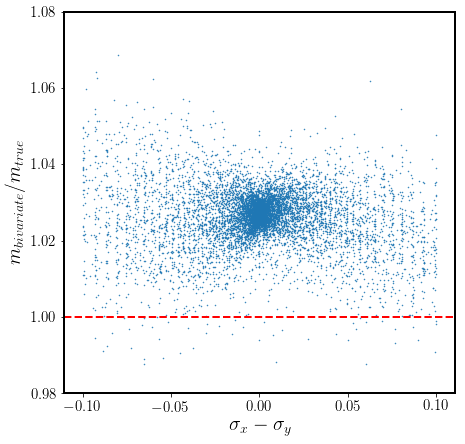

In [555]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter(t['sigma_x'] - t['sigma_y'] , t['slope_biv']/slope_truth, s=0.25)
ax.set_ylim(0.98,1.08)
ax.axhline(1,ls='--', lw='2', c='r')
ax.set_ylabel(r'$m_{bivariate} / m_{true}$')
ax.set_xlabel(r'$\sigma_{x} - \sigma_{y}$')
plt.savefig('bivariate_fit_sig_x_sig_y_biv.png', bbox_inches='tight', dpi=100)

Meanwhile,  for bivariate distribution, it's insensitive to errors, because it doesn't take them into consideration...

(-1, 0)

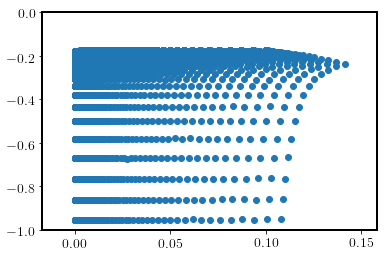

In [398]:
plt.scatter(np.sqrt(t['sigma_x']**2 + t['sigma_y']**2), t['slope_tls'])
plt.ylim(-1,0)

(array([3826., 1709.,  279.,  181.,  177.,  174.,  238.,  324.,  755.,
        2325.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

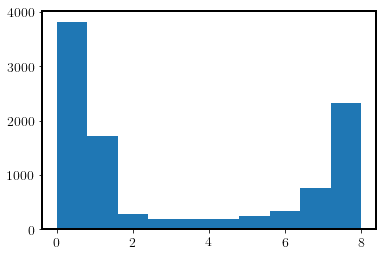

In [307]:
slope_truth = -0.23 
plt.hist(t['slope_tls'] / slope_truth, range=(0,8.))#, range=(-3,2))

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3904., 1046.,  394.,  284.,   94.,  183.,  179.,  175.,  325.,
         921.]),
 array([-0.2  , -0.095,  0.01 ,  0.115,  0.22 ,  0.325,  0.43 ,  0.535,
         0.64 ,  0.745,  0.85 ]),
 <a list of 10 Patch objects>)

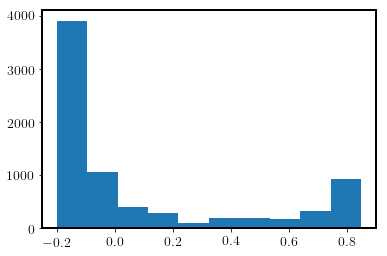

In [355]:
slope_truth = -0.23 
plt.hist(np.log10(t['slope_tls'] / slope_truth), range=(-0.2,.85))#, range=(-3,2))

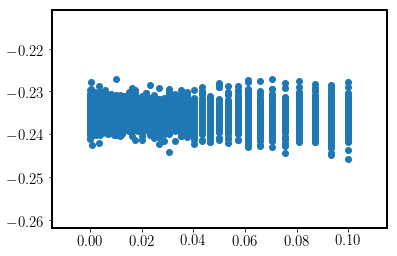

In [482]:
plt.scatter(t['sigma_y'], t['slope_biv'])

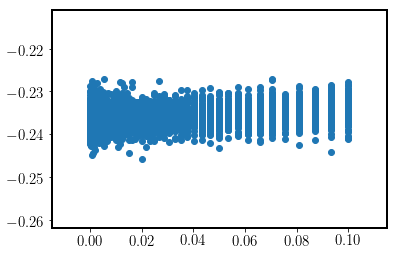

In [483]:
plt.scatter(t['sigma_x'], t['slope_biv'])

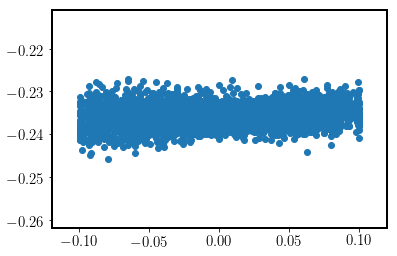

In [484]:
plt.scatter(t['sigma_x']-t['sigma_y'], t['slope_biv'])

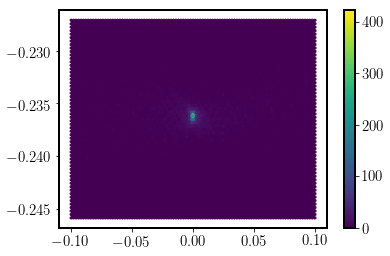

In [481]:
plt.hexbin(t['sigma_x']-t['sigma_y'], 
           t['slope_biv'])
plt.colorbar()

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


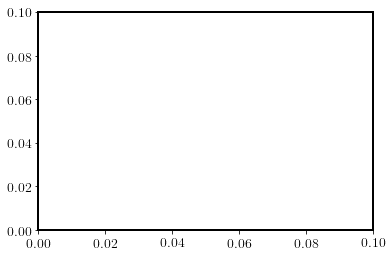

In [263]:
from scipy.stats import binned_statistic_2d
stats = binned_statistic_2d(sig_x_col,sig_y_col,sl_tls_col, 
                           statistic = 'median',)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
image = plt.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))

In [236]:
image

In [264]:
x = sig_x_col
y = sig_y_col
z_list = sl_tls_col
H, bins = np.histogramdd(x, bins=2 * [np.linspace(-4.5, 4.5, 51)])
ax.imshow(H, origin='lower', cmap=plt.cm.binary, interpolation='nearest',
          extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])



ValueError: The dimension of bins must be equal to the dimension of the  sample x.

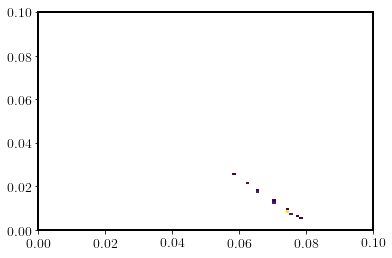

In [265]:
x_list = sig_x_col
y_list = sig_y_col
z_list = sl_tls_col

N = int(len(z_list)**.5)
z = z_list.reshape(N, N)
from matplotlib.colors import LogNorm
plt.imshow(z, extent=(np.amin(x_list), np.amax(x_list), 
                      np.amin(y_list), np.amax(y_list)), 
           norm=LogNorm(), aspect = 'auto')



In [87]:
# an y=x line  with slope =1  has a 45 degree angle ...
# np.arctan(1) gives the angle corresponding to that slope in radians, and 
# np.rad2deg converts the radians to degrees 
# np.rad2deg(np.arctan(1))

# so line with slope -0.23 has a degree 


0.2260683879938839

Use AstroML TLS as well as bivariate distr. to fit Fig.17 distributions of $SF_{\infty,4000}$ vs $L/L_{Edd}$  , using Chelsea data ... 

In [572]:

def fit_tls_bivariate(x1,y1,sigma_x, sigma_y, verbose=True):
    X = np.vstack((x1,y1)).T
    dX =  np.zeros((len(x1), 2, 2))
    dX[:,0,0] = sigma_x ** 2.0 
    dX[:,1,1] = sigma_y ** 2.0 
    dX[:,0,1] = dX[:,1,0] = 0 # cov_xy : we assume errors are uncorrelated 

    min_func = lambda beta: -TLS_logL(beta, X, dX)
    beta_fit = optimize.fmin(min_func,x0=[1,-1], disp=0)
    #print(beta_fit)
    def get_m_b(beta):
        b = np.dot(beta, beta) / beta[1]
        m = -beta[0] / beta[1]
        return m, b
    slope_tls, offset_tls  = get_m_b(beta_fit)
    if verbose:
        print('Recovered slope with AstroML (incl.errors): ', slope_tls)
        
    # fit with astroML code, robust fit 
    (mu_r, sigma1_r, sigma2_r, alpha_r) = fit_bivariate_normal(x1, y1, robust=True)
    slope_bivariate = np.tan(alpha_r) # alpha is rotation in radians 
    if  verbose : 
        print('Fitting robust bivariate dist. the slope is ', slope_bivariate )
        
    return slope_tls, offset_tls, slope_bivariate



In [603]:
qso_ = Table.read('../code/s82drw_ugriz_shen2011_shen2008.txt', format='ascii')
qso = qso_#[:1000]

In [ ]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import seaborn as sns

cmap = 'cubehelix'

# plotted quantities : 
# absolute i-band magnitude K-corr to z=2 
MI = qso['MI_Z2'] # Shen2011 
#MI = qso['M_i_corr']
# redshift  : Shen2011 
z =  qso['REDSHIFT']
#z = qso['redshift']
# black hole mass from Shen+2011
MBH = qso['LOGBH']
#MBH = qso['mass_BH']

# Eddington ratio : Shen2011
# log(L/LEdd ) = log( L / 1.26e38 MBH / Msun)

logEddRatio = qso['LOGEDD_RATIO'] # Shen2011
#logEddRatio = qso['LOGLBOL'] - np.log10(1.5) - 38 - qso['LOGBH']  # Shen 2011 but with 
# Chlsea's definition of LEdd (1.5 rather than 1.26 )
#logEddRatio = qso['Lbol'] - np.log10(1.5) - 38 - qso['mass_BH_1']  # shen 2008


#lambdaobs = 6250 # angstroms  - since these are the results for 
# combined SDSS r-band, centered on 6250 Angstroms 
#lambdaRF = lambdaobs /  (1.+z)

#seg = 'sdss-ps1' # sdss'# 'sdss-ps1'

#tauRF = qso['tauEXP_'+seg] / (1.+z)  # shift to rest frame 
#tau4000 = tauRF * np.power(4000/lambdaRF, 0.17) # B=0.17 for tau

#sfinf = qso['sigmaEXP_'+seg] * np.sqrt(2) # no need to shift anything 
#sfinf = qso['SFinf']
#sf4000 = sfinf * np.power(4000 / lambdaRF, -0.479 ) # B = -0.479 for SFinf 
sf4000 = qso['SFinf4000']

fig,axs = plt.subplots(1,2, figsize=(11,5))
ax = np.ravel(axs)

gridsize=20
m = logEddRatio  >  -4 
#m = (qso['tauEXP_'+seg] > 5 )&(logEddRatio > -4)


# if seg == 'sdss-ps1':
#     extent0 = [7,11, -23,-29]
#     extent1 = [-2.6,0.6, -1.2,-0.2]
    
# if seg == 'sdss':
#     extent0 = [7,11, -23,-29]
#     extent1 = [-2.6,0.6, -1.2,-0.2]
    
# left panel 
image = ax[0].hexbin(MBH[m], MI[m], logEddRatio[m],
            extent = extent0, cmap=cmap, gridsize=gridsize)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$\log_{10}{(M_{BH}/M_{\odot})}$')
ax[0].set_ylabel(r'$\log_{10}{(M_{i})}$')


left, bottom, width, height = 0.12, 1.03, 0.36, 0.02
cax = fig.add_axes([left,bottom,width,height])
plt.colorbar(mappable = image, cax = cax, orientation='horizontal',
            label=r'$\log_{10}{(L_{bol} / L_{Edd} )}$')

# right panel

#ax[1].scatter(logEddRatio, np.log10(sf4000), s=0.05, c='blue')
x,y = logEddRatio[m].data, np.log10(sf4000[m].data)


ax[1].set_xlim(extent1[0],extent1[1])
ax[1].set_ylim(extent1[2],extent1[3])
ax[1].hexbin(x,y,bins='log',mincnt=1, gridsize=gridsize,
            extent = extent1)


# contours with single color
sns.kdeplot(x,y, n_levels=6, ax=ax[1],
                linestyles='-', linewidth=2, cmap=None, colors='red', )
# shaded contours
#sns.kdeplot(x,y, n_levels=6, ax=ax[1],
#                linestyles='-', linewidth=2, cmap='Blues_r', )


# plot the medians too ..
xlim = ax[1].get_xlim()
min_x, max_x , step_size = xlim[0],xlim[1], 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))
for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
    median_y[j] = np.median(y[mask])
    
ax[1].scatter(mean_x[:-1], median_y[:-1], c = 'magenta', edgecolor='yellow')
ax[1].errorbar(mean_x, median_y, yerr = sigma_y, xerr = sigma_x, 
            ecolor='brown', elinewidth=1, fmt='none')

# stats on log ... 
#stats = binned_statistic(x,y,statistic = 'median', bins=40)
#bins = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2
#ax[1].scatter(bins,  stats.statistic,  c = 'magenta', edgecolors='orange')

#bins =  np.linspace(np.power(10,xmin), np.power(10,xmax), 40)
#stats = binned_statistic(np.power(10,x), np.power(10,y), statistic='median', bins=bins)
#bins = (stats.bin_edges[1:] + stats.bin_edges[:-1])/2
#ax[1].scatter(np.log10(bins),  np.log10(stats.statistic),
#              c = 'magenta', edgecolors='orange')

lw = 3
fit_medians = False
if fit_medians: # fit the medians 
    print('Fitting the medians ')
    mask_bad = ~np.isnan(median_y)
    x1=mean_x[mask_bad] ;  y1 = median_y[mask_bad]
    ax[1].set_title('Shen2011, M10 data, fit median(y)')
    fname =  'Eddington_ratio_Shen2011_Chelsea_SDSS_ugriz_median_y.png'
    
if not fit_medians: # fit the distributon 
    print('Fitting the observed distribution ')
    x1=x ; y1 = y
    ax[1].set_title('Shen2011, M10 data, fit x,y')
    fname =  'Eddington_ratio_Shen2011_Chelsea_SDSS_ugriz_x_y.png'
    
slope_tls, offset_tls, slope_bivariate = fit_tls_bivariate(x1,y1,
                                           sigma_x=0.2, sigma_y=0.01)
# plot the fitted slopes 
x_ = np.linspace(min(x),max(x),100)
ax[1].plot(x_, x_*slope_tls+offset_tls, c='orange',lw=lw,
          label='TLS: '+str(slope_tls.round(3)))
if not fit_medians: 
    ax[1].plot(x_, x_*slope_bivariate -0.93, c='red',lw=lw,
              label='Bivariate: '+str(slope_bivariate.round(3)))


ax[1].set_ylabel(r'$\log_{10}{(SF_{\infty})}$')
ax[1].set_xlabel(r'$\log_{10}{(L_{bol} / L_{Edd})}$')

#ax[1].plot(x, func(x,-0.9, -1.5 ), ls = '--', lw=3, c='orange',label='-0.9')

# plot Chelsea's slope...
x_ = np.linspace(-2.6,0.6)
ax[1].plot(x_, -0.23*x_ - 0.93, lw=lw, ls='--', c='magenta', label='M10: -0.23')

#ax[1].legend(loc='upper left', bbox_to_anchor=(1,1),
#            ncol=1, fancybox=True, shadow=True, fontsize=18 ) 
ax[1].legend(fancybox=True, shadow=True,framealpha=0.7 )

fig.subplots_adjust(wspace=0.3)
#plt.savefig('macleod2010_Fig15_shen2011_SDSS-PS1.png', bbox_inches='tight')
#fname =  'Eddington_ratio_Shen2011_'+seg+'.png'

print('Saved as ', fname)
plt.savefig(fname,   bbox_inches='tight', dpi=100)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [611]:
plt.errorbar?